## Optimized Variational Auto-Encoder (VAE) for Airfoil Shape Optimization
Variational autoencoder defined by:  
- 198 input coordinates  
- 4 latent variables  
- Symmetric [466, 167, 234] MLP architecture  
- k = 5e-6 for the loss function  

Training parameters:
- Batch size = 32  
- Epochs = 5000  
- Optimizer = Adam (default)
- Uses the whole dataset, not just training set

In [1]:
# Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.nn import functional as F
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from AirfoilVAE import AirfoilVAE
from compute_fid import compute_fid


plt.style.use('seaborn-whitegrid')

In [2]:
# Library options
pd.options.mode.chained_assignment = None  # default='warn'
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

# Get CPU or GPU device for NN
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
print(f"CUDA version: {torch.version.cuda}")

Using cuda device
CUDA version: 11.1


In [8]:
# Parameters
batch_size = 256
epochs = 5000
kld_weight_coef = 5e-6
hidden_dims = [466, 167, 234]
latent_dim = 4

In [30]:
# Helper functions
def airfoil_plot(airfoil_coords, linestyle=None, fig=None, label=None, title=None, spacing='cosine', n_points=198):
    """
    Returns a plot of an airfoil. Used to visualize output of the optimizer. 
    Assumes 15 points for upper surface and 15 points for lower surface, with cosine spacing.
    NOTE: This function should be edited depending on the database.
    Inputs:
        - airfoil_coords: pandas DataFrame with airfoil coordinates and other parameters
    Outputs:
        - Plot of airfoil shape
    """
    if fig==None:
        fig = plt.subplot2grid((1,3), (0,0), colspan = 3)
    
    # X coordinates
    points_per_surf = int(n_points/2)
    if spacing == 'cosine':
        x = list(reversed([0.5*(1-np.cos(ang)) for ang in np.linspace(0,np.pi,points_per_surf+2)]))
        aux_x = list([0.5*(1-np.cos(ang)) for ang in np.linspace(0,np.pi,points_per_surf+2)[1:points_per_surf+1]])
        [x.append(i) for i in aux_x]
        x.append(1)

    elif spacing == 'linear':
        x = list(reversed(list(np.linspace(0,1,points_per_surf+2))))
        aux_x = list(list(np.linspace(0,1,points_per_surf+2)[1:points_per_surf+1]))
        [x.append(i) for i in aux_x]
        x.append(1)    

    # Y coordinates
    y = []
    origin = (airfoil_coords.iloc[0][0]+airfoil_coords.iloc[0][points_per_surf])/2
    y.append(0)
    [y.append(j) for j in airfoil_coords.iloc[0][0:points_per_surf].values.tolist()]
    y.append(origin)
    #aux_y = list(reversed(airfoil_coords.iloc[points_per_surf:n_points].values.tolist()))
    aux_y = list(airfoil_coords.iloc[0][points_per_surf:n_points].values.tolist())
    [y.append(k) for k in aux_y]
    y.append(0)

    # Airfoil plot
    if linestyle is not None:
        fig.plot(x, y, label = label, color='black', linestyle=linestyle)
    else:
        fig.plot(x, y, label = label)
    fig.set_xlim([-0.1,1.1])
    fig.set_ylim([-0.2,0.3])
    fig.set_ylabel('$y/c$')
    fig.set_xlabel('$x/c$') 
    if title is not None:
        fig.set_title(title, fontsize=16)
    else:
        fig.set_title('Airfoil plot', fontsize=16)
    fig.legend(frameon=True)
    if fig==None:
        plt.show()
    return


def torch_test_split(X, y = None, test_size=0.2, seed=1234):
    """
    Returns a train and test set in PyTorch tensor format from a numpy array dataset.
    Inputs:
        - X: numpy array with input data. Each row is a training/testing sample and each column is a feature.
        - y: numpy array with output data. Each row is a training/testing sample and each column is an output.
        - test_size: proportion of the dataset to be used as test set.
        - seed: random seed for reproducibility.
    Outputs:
        - training_data: PyTorch tensor with training data.
        - test_data: PyTorch tensor with test data.
    """
    X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X, y, test_size=test_size, random_state=seed)
    X_train = torch.from_numpy(X_train_0).float()
    X_test = torch.from_numpy(X_test_0).float()
    y_train = torch.from_numpy(y_train_0).float()
    y_test = torch.from_numpy(y_test_0).float()
    training_data = []
    testing_data = []
    for i in range(len(X_train)):
        training_data.append((X_train[i], y_train[i]))
    for i in range(len(X_test)):
        testing_data.append((X_test[i], y_test[i]))
    return training_data, testing_data

def normalize_data (data, scaler):
    """
    Normalizes neural network inputs and outputs.
    Inputs:
        - data: data to be normalized. [np.array / pd.DataFrame]
        - scaler: pre-fitted scaler object.
    Outputs:
        - normalized data. [pd.DataFrame]
    """
    if type(data) == pd.DataFrame:
        data = data.to_numpy().reshape(-1,scaler.n_features_in_)
    elif type(data) == np.ndarray:
        data = data.reshape(-1,scaler.n_features_in_)
    else:
        raise(TypeError('Input data must be either a pd.DataFrame or a np.ndarray'))
    norm_data = pd.DataFrame(data = scaler.transform(data), columns = scaler.feature_names_in_)
    return norm_data

def denormalize_data (data, scaler):
    """
    Denormalizes neural network inputs and outputs.
    Inputs:
        - data: data to be denormalized. [np.array / pd.DataFrame]
        - scaler: pre-fitted scaler object.
    Outputs:
        - denormalized data. [pd.DataFrame]
    """
    if type(data) == pd.DataFrame:
        data = data.to_numpy().reshape(-1,scaler.n_features_in_)
    elif type(data) == np.ndarray:
        data = data.reshape(-1,scaler.n_features_in_)
    else:
        raise(TypeError('Input data must be either a pd.DataFrame or a np.ndarray'))
    denorm_data = pd.DataFrame(data = scaler.inverse_transform(data), columns = scaler.feature_names_in_)
    return denorm_data

def init_weights(m):
    """
    Resets all the weights in a given model. Uses a normal distribution with varying standard deviation for each weight depending on the layer type.
    To be applied to a PyTorch model object as model.apply(init_weights).
    Obtained from: https://stackoverflow.com/questions/64699434/reset-model-parameters-and-weights-of-a-network-pytorch-for-cross-validation
    """
    if isinstance(m, nn.Embedding):
        nn.init.normal_(m.weight, mean=0.0, std=0.1) ## or simply use your layer.reset_parameters()
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0.0, std=np.sqrt(1 / m.in_features))
        if m.bias is not None: 
            nn.init.zeros_(m.bias)
    if isinstance(m, nn.Conv1d):
            nn.init.normal_(m.weight, mean=0.0, std=np.sqrt(4 / m.in_channels))
            if m.bias is not None: 
                nn.init.zeros_(m.bias)
                
def train(dataloader, model, loss_fn, optimizer, loss_output = None, recon_output = None, kld_output = None, mse_output = None, weight = 1):
    size = len(dataloader.dataset)
    model.train()
    batchnum = len(dataloader)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, weight = weight)

        # Backpropagation
        optimizer.zero_grad()
        loss['loss'].backward()
        optimizer.step()

        if batch % 10 == 0:
            losspr, current = loss['loss'].item(), batch * len(X)
            print(f"loss: {losspr:>7f}  [{current:>5d}/{size:>5d}]")
        elif batch == batchnum-1:
            losspr = loss['loss'].item()
            print(f"loss: {losspr:>7f}  [{size:>5d}/{size:>5d}]")
            
    if loss_output is not None:
        try:
            loss_output.append(loss['loss'].item())
            recon_output.append(loss['recon_loss'].item())
            kld_output.append(loss['kl_loss'].item())
            mse_output.append(loss['mse_loss'].item())
        except:
            pass


In [10]:
# Define input dataset (.csv) name and path
data_folder = './data/'
dataset_name = 'NACA4Digit_Dataset15Point.csv'
dataset_name = 'UIUC_dataset_198p.csv'

# Import dataset
airfoil_df = pd.read_csv(data_folder + dataset_name)
try:
    airfoil_df = airfoil_df.drop('Unnamed: 0', axis=1)    # Remove first column, counter
except: pass
num_coords = int(sum([1 for col in airfoil_df if col.startswith('y')]))
print(f'Number of airfoil coordinates: {num_coords}')
airfoil_df = airfoil_df.drop_duplicates(subset=['yU_1'], keep='first')    # Remove duplicate airfoil coordinates

airfoil_df.head()

# Data scaler fitting
scaler = MinMaxScaler()
scaler.fit(airfoil_df)

# Assemble a DataFrame with all the minimum and maximum values of each column
# For normalization and de-normalization. Gives an idea of the bounds.
scaler_bounds = pd.DataFrame(data = np.stack([scaler.feature_names_in_, scaler.data_min_, scaler.data_max_], axis=1), columns=['property', 'min', 'max'])

# Data normalization
airfoil_df_norm = normalize_data(airfoil_df, scaler)

# Input and "output" features
# Input and output features are both the same for this dataset.
try:
    X = airfoil_df_norm.drop(['Cl', 'Cd', 'Cm', 'ReynoldsNumber', 'MachNumber', 'alpha'], axis=1).values
except: 
    X = airfoil_df_norm.values

# Data tensors
training_data, test_data  = torch_test_split(X, X, test_size=1)

train_dataloader = DataLoader(training_data, batch_size=batch_size)

for X, y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape} {y.dtype}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Number of airfoil coordinates: 198
Shape of X [N, C, H, W]: torch.Size([256, 198]) torch.float32
Shape of y: torch.Size([256, 198]) torch.float32


C:\Users\Roman\anaconda3\envs\pytorch19\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [16]:
# Convert the scaler bounds variable to a dictionary for use with the sampler
convert = False

if convert is True:
    scaler_dict = {}
    for key in scaler_bounds['property']:
        min = scaler_bounds[scaler_bounds['property'] == key]['min'].values[0]
        max = scaler_bounds[scaler_bounds['property'] == key]['max'].values[0]
        scaler_dict[key] = {'min': min, 'max': max}

    with open('scaler_dict.json', 'w') as fp:
        json.dump(scaler_dict, fp, indent=4)

In [12]:
# Define model - AirfoilVAE
in_channels = num_coords

model = AirfoilVAE(in_channels = in_channels,
                   latent_dim = latent_dim,
                   hidden_dims = hidden_dims).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
print(model)

AirfoilVAE(
  (encoder): Sequential(
    (0): Linear(in_features=198, out_features=466, bias=True)
    (1): ELU(alpha=1.0)
    (2): Sequential(
      (0): Linear(in_features=466, out_features=167, bias=True)
      (1): ELU(alpha=1.0)
    )
    (3): Sequential(
      (0): Linear(in_features=167, out_features=234, bias=True)
      (1): ELU(alpha=1.0)
    )
  )
  (fc_mu): Linear(in_features=234, out_features=4, bias=True)
  (fc_var): Linear(in_features=234, out_features=4, bias=True)
  (decoder_input): Linear(in_features=4, out_features=234, bias=True)
  (decoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=234, out_features=167, bias=True)
      (1): ELU(alpha=1.0)
    )
    (1): Sequential(
      (0): Linear(in_features=167, out_features=466, bias=True)
      (1): ELU(alpha=1.0)
    )
    (2): Linear(in_features=466, out_features=198, bias=True)
  )
)


Epoch 1
-------------------------------
loss: 0.317977  [    0/ 1426]
loss: 0.179473  [ 1426/ 1426]
Epoch 2
-------------------------------
loss: 0.125832  [    0/ 1426]
loss: 0.053540  [ 1426/ 1426]
Epoch 3
-------------------------------
loss: 0.027604  [    0/ 1426]
loss: 0.028419  [ 1426/ 1426]
Epoch 4
-------------------------------
loss: 0.025121  [    0/ 1426]
loss: 0.016239  [ 1426/ 1426]
Epoch 5
-------------------------------
loss: 0.012968  [    0/ 1426]
loss: 0.012191  [ 1426/ 1426]
Epoch 6
-------------------------------
loss: 0.008015  [    0/ 1426]
loss: 0.012428  [ 1426/ 1426]
Epoch 7
-------------------------------
loss: 0.008757  [    0/ 1426]
loss: 0.010624  [ 1426/ 1426]
Epoch 8
-------------------------------
loss: 0.007313  [    0/ 1426]
loss: 0.009523  [ 1426/ 1426]
Epoch 9
-------------------------------
loss: 0.006222  [    0/ 1426]
loss: 0.009415  [ 1426/ 1426]
Epoch 10
-------------------------------
loss: 0.006153  [    0/ 1426]
loss: 0.009294  [ 1426/ 1426]

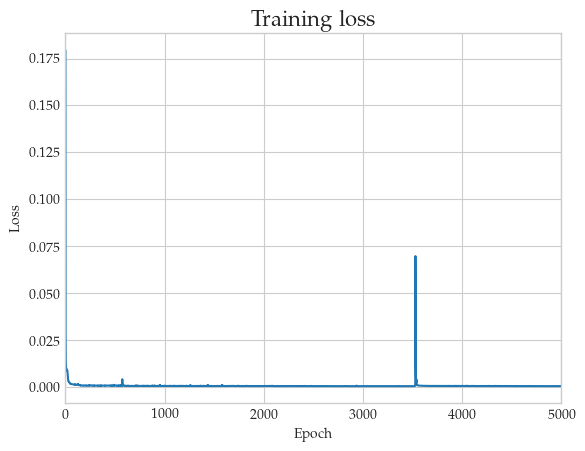

FID = 0.0078


In [42]:
# Run training
loss_plot = []
recon_plot = []
kld_plot = []
mse_plot = []
for t in range(epochs):
    kld_weight = kld_weight_coef*(t/20 if t/20 <= 1 else 1)
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, model.loss_function, optimizer, loss_output = loss_plot, recon_output = recon_plot, kld_output = kld_plot, mse_output = mse_plot, weight = kld_weight)
print("Done!")

# Loss plot
plt.plot(range(1, epochs+1), loss_plot)
plt.ylabel('Loss')
plt.xlabel('Epoch') 
plt.title('Training loss', fontsize=16)
plt.xlim([0,epochs])
plt.show()

# Compute FID
sampled_norm = model.sample(10000, 'cuda', std_coef = 1)
sampled = denormalize_data(sampled_norm.detach().cpu().numpy(),scaler)
fid = compute_fid(airfoil_df.to_numpy(), sampled)
print(f'FID = {fid:.4f}')

In [94]:
# Compute FID
sampled_norm = model.sample(10000, device, std_coef = 1)
sampled = denormalize_data(sampled_norm.detach().cpu().numpy(),scaler)
fid = compute_fid(airfoil_df.to_numpy(), sampled)
print(f'FID = {fid:.4f}')

FID = 0.0011


In [20]:
# Save the model
save_model = True
model_name = f'{model.name}_{epochs}ep_k{kld_weight_coef}_b{batch_size}.pth'

if save_model:
    trained_root = "./final_model/"
    
    model_path = trained_root + model_name
    torch.save(model.state_dict(), model_path)
    print(f"Saved PyTorch Model State to {model_path}")

Saved PyTorch Model State to ./final_model/VAE_MLP466_198_4_5000ep_k5e-06_b256.pth


In [19]:
# Loading the model
device = 'cpu'
model = AirfoilVAE(in_channels = in_channels,
            latent_dim = latent_dim,
            hidden_dims = hidden_dims).to(device)

model_root = "./archive/trained_models/"
model_name = f'{model.name}_{epochs}ep_k{kld_weight_coef}_b{batch_size}.pth'

model_path = model_root + model_name
model.load_state_dict(torch.load(model_path, map_location=device))

<All keys matched successfully>